## BUAN6341.003 Applied Machine Learning Assigment 4 submitted by:          Pingili Lohith

#### In this assignment, the follwing two clustering  algorithms are implemented on two datasets:
1. K Means 
2. Expectation Maximization

After clustering, dimensionality reduction algorithms - feature selection, PCA, ICA, Randomized projections. Dimensionality reduced features were further used for clustering and neural networks.

About the datasets: 
1. First dataset is  Online News Sharing dataset available for download at https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity# .The goal is to predict the number of time an article is shared based on features like number of images, number of videos, day of publication, type of article, referenced article shares etc. By converting the shares variable to a class variable based on median values, we try to classify an article being shared or not  based on the above features. Classification of this kind is interesting as it can help in revenue generation.
2. Second data is Adult dataset available for download at https://archive.ics.uci.edu/ml/datasets/Census+Income, a clean version of which available at https://github.com/udacity/machine-learning/tree/master/projects/finding_donors is used. The goal is to predict whether income exceeds 50K/yr based on census data based on features like sex, education type, years of education, relationship status, race etc. By converting the income variable to a class variable based on >50k/yr and <=50k/yr , we try to classify whether the person's income exceeds $50k/yr. This kind of classification can be of interest to  a non-profit organisation, where organizations survive on donations. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.

The procedure followed in the implementation of these algorithms(first on first dataset and second on second dataset) is as follows:
1. Task1: Implemented k-Means and Expectation maximization and plotted variation of clusters across the dependent variable.
2. Task2: Dimensionality reduction alogorithms were applied and plots describing the selected features are shown.
3. Task3: Implemented the clustering algorithms on the features obtained in task2. plotted variation of clusters across the dependent variable.
4. Task4: Neural network learner from assignment 3 with the best parameters was implemeted on the features obtained from task2. Time taken for different reuction algorithms(PCA,ICA etc) was calculated. Accuracy and loss curves are plotted.
5. Task5. The clustering results from task1 were converted to dummy variables and used as features on the optimized neural network learner from assignment 3. 
Libraries used: pandas, numpy, scikitlearn, keras, seaborn and matplotlib

Note: Every task is followed by the findings from that task.

In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from scipy.stats import kurtosis
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
import random
from keras.models import Sequential
from keras.layers.core import Dense, Activation

In [189]:
%config IPCompleter.greedy=True

### First dataset

In [194]:
df1=pd.read_csv('OnlineNewsPopularity.csv')

In [195]:
shares=df1['shares']
features=df1.drop(['url','timedelta','shares'],axis=1)
df1_t = df1.drop(['url','timedelta','shares'],axis=1)

In [196]:
features = (features - features.min()) / (features.max() - features.min())
df1_t = (df1_t - df1_t.min()) / (df1_t.max() - df1_t.min())

In [197]:
#Creation of binary variable for shares based on median.
median_shares=np.median(shares)
shares_ind=[]
for share in shares:
    if share>= median_shares:
        shares_ind.append(1)
    else:
        shares_ind.append(0)
shares=pd.DataFrame(shares_ind)
shares=np.ravel(shares)

#### K-Means

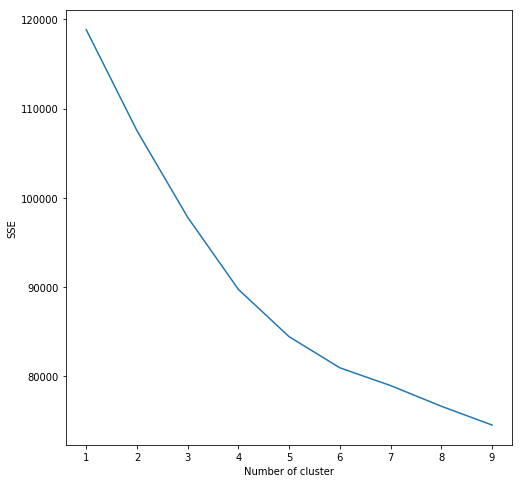

In [198]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k,random_state=123).fit(features)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(8,8))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

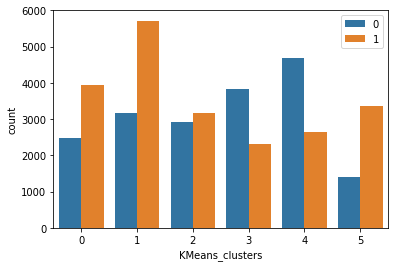

In [277]:
# Plot showing distribution of clusters across dependent variable
df1_Kmeans = KMeans(n_clusters=6,random_state=123).fit(features)
df1_t['KMeans_clusters'] = df1_Kmeans.labels_
sns.countplot(df1_t['KMeans_clusters'],hue=shares)

#### Findings:
1. Using the elbow method, the optimum number of clusters is 6.
2. Cluster 1 has the most number of shares-1 class label
3. Cluster 3 has the least number of shares-0 class label

#### Expectation Maximization 

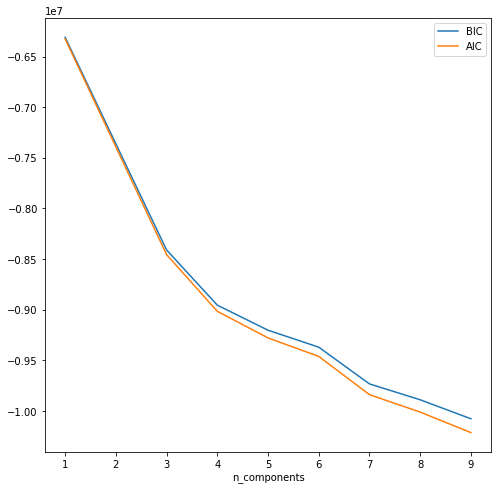

In [216]:
n_components = np.arange(1, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=123).fit(features)
          for n in n_components]
plt.figure(figsize=(8,8))
plt.plot(n_components, [m.bic(features) for m in models], label='BIC')
plt.plot(n_components, [m.aic(features) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

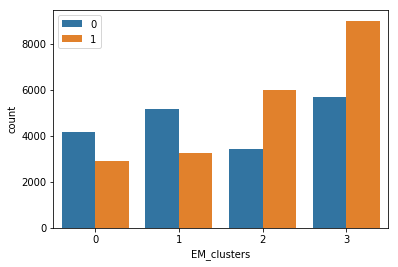

In [278]:
# Plot showing distribution of clusters across dependent variable
df1_EM = GaussianMixture(4, random_state=123).fit(features)
df1_EM.predict(features).shape
df1_t['EM_clusters'] = df1_EM.predict(features)
sns.countplot(df1_t['EM_clusters'],hue=shares)

#### Findings
1. Based on elbow method (with both AIC and BIC scores), the optimum number of clusters is 4
2. The number of samples  is increasing from cluster 0-3
3. Cluster 3 has the most number of samples across class labels (shares-0 and shars-1 )

#### Dimensionality Reduction

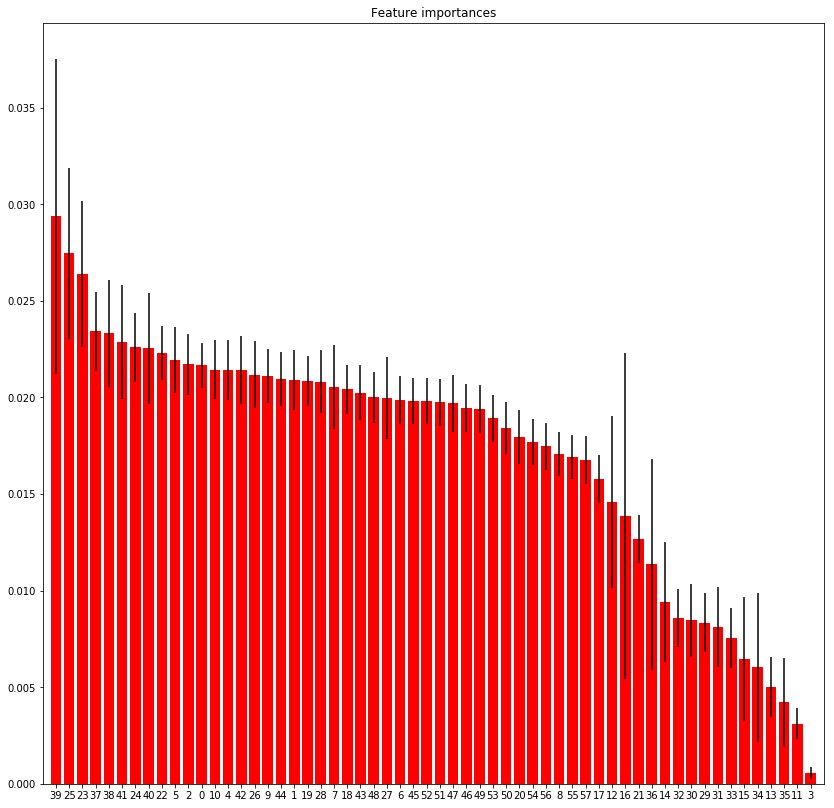

In [387]:
#Graph showing the feature importances of the original features
X=features
y=shares
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=123)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


# Plot the feature importances of the forest
plt.figure(figsize=(14,14))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [205]:
# Dimensionality reduction using tree feature selection
model = SelectFromModel(forest, prefit=True)
df1_dt = pd.DataFrame(model.transform(X))

#### PCA for first dataset

In [253]:
pca=PCA(.90).fit(features)
pca.n_components_

18

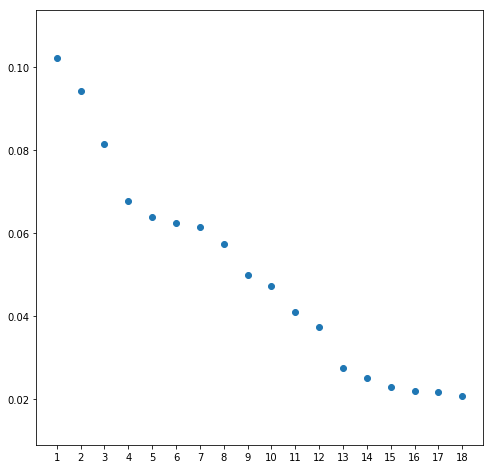

In [270]:
# Plot showing feature variance after PCA
plt.figure(figsize=(8,8))
plt.scatter(list(range(1,19)),pca.explained_variance_ratio_)
plt.xticks(range(1,19))
plt.show()

In [207]:
df1_PCA = pd.DataFrame(PCA(n_components=18).fit_transform(features))

#### ICA for first dataset

In [208]:
df1_ICA = pd.DataFrame(FastICA().fit_transform(features))

C:\Users\pvloh\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


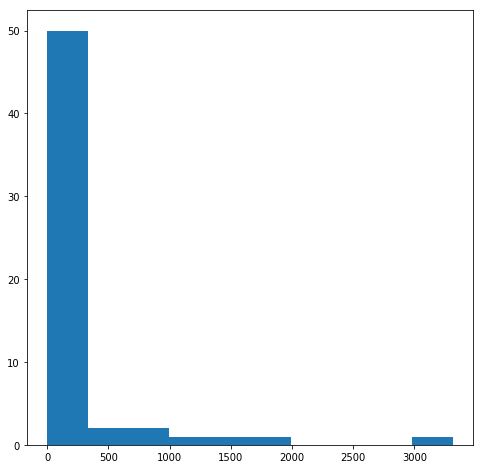

In [332]:
#PLot showing distribution of kurtosis score after ICA
df1_kurtosis = []
for column in df1_ICA:
    df1_kurtosis.append(kurtosis(df1_ICA[column],fisher=True))
plt.figure(figsize=(8,8))
plt.hist(df1_kurtosis)
plt.show()

In [209]:
df1_ica = pd.DataFrame()
for column in df1_ICA:
    if abs(kurtosis(df1_ICA[column],fisher=True)) < 1 :
        df1_ica[column]=df1_ICA[column]

#### RandomProjection

In [210]:
def custom1(data, orig_dimension, new_dimension):
    minusOne = 0.2
    one = 0.7
    rows = len(data)
    m = np.empty((orig_dimension, new_dimension))
    # build random matrix
    for i in range(len(m)):
        for j in range(len(m[i])):
            rand = random.random()
            if rand < minusOne:
                m[i][j] = -1
            elif rand >= one:
                m[i][j] = 1
            else:
                m[i][j] = 0
    reduced = np.mat(data) * m
    #reduced=""
    return reduced

In [211]:
df1_random = pd.DataFrame(custom1(features, 58, 30))

#### Findings for task 2 dataset 1
1. Feature selection(using trees) algorithm chose 18 features as the best features. 
2. The graph for feature selection shows that the highest variance explained by a feature is 0.029. Almost all the features show an equal variance
3. With 90% explained variance, PCA resulted in 18 features.
4. The plot for the PCA shows that the the highest variance explained by a feature is 0.11, which is a huge improved compared to the original variance.
5. Using kurtosis distance as a metric (absolute value greater than 1), ICA resulted in 10 features. 
6. The graph for ICA shows that almost 90% of new features have kurtosis distance in the 0-500 range with 10 below 1.Absolte value of kurtosis distance was used.
7. Using a ramdom matrix, 30(~half of original number of features) was chosen as the new featues from randomized projections. 

#### Task 3.Clustering with dimensionality reduced data

#### K-means with reduced dimensions 

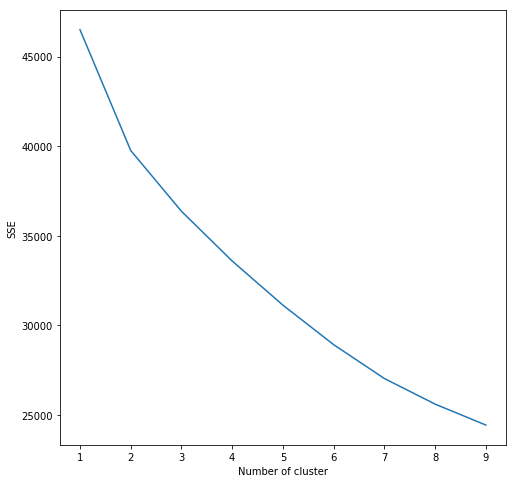

In [212]:
# K-means with feature selection
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k,random_state=123).fit(df1_dt)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(8,8))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

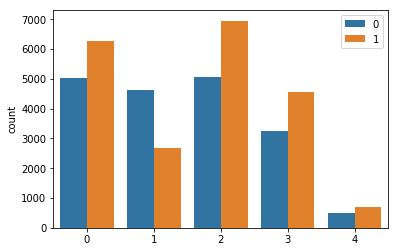

In [362]:
# Plot showing distribution of clusters across dependent variable
df1_Kmeans_dt = KMeans(n_clusters=5,random_state=123).fit(df1_dt)
sns.countplot(df1_Kmeans_dt.labels_,hue=shares)

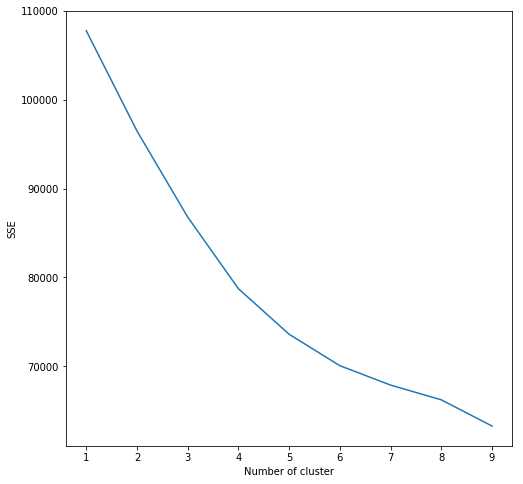

In [213]:
#K-means with PCA
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k,random_state=123).fit(df1_PCA)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(8,8))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

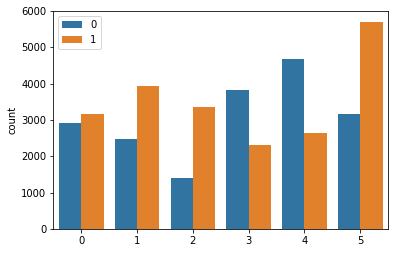

In [363]:
# Plot showing distribution of clusters across dependent variable
df1_Kmeans_PCA = KMeans(n_clusters=6,random_state=123).fit(df1_PCA)
sns.countplot(df1_Kmeans_PCA.labels_,hue=shares)

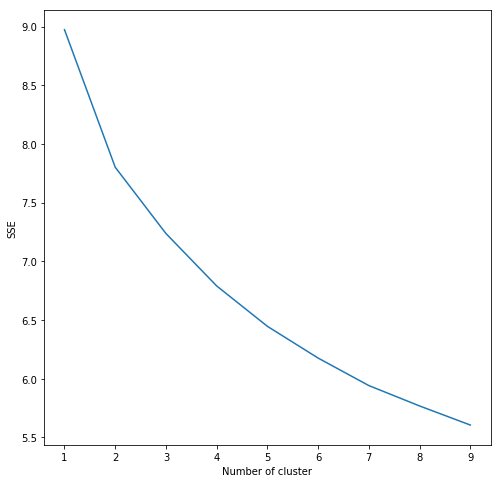

In [107]:
#K-means with ICA
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k,random_state=123).fit(df1_ica)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(8,8))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

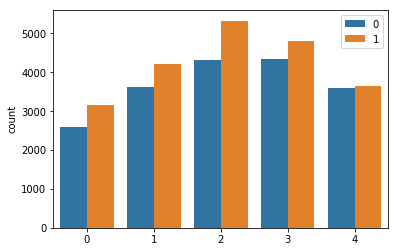

In [364]:
# Plot showing distribution of clusters across dependent variable
df1_Kmeans_ica = KMeans(n_clusters=5,random_state=123).fit(df1_ica)
sns.countplot(df1_Kmeans_ica.labels_,hue=shares)

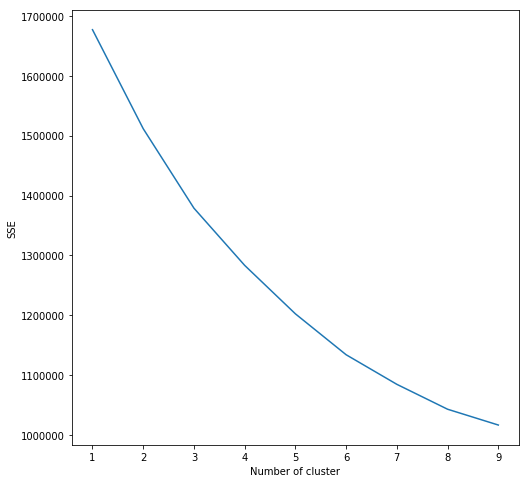

In [214]:
#K-means with randomized projections
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k,random_state=123).fit(df1_random)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(8,8))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

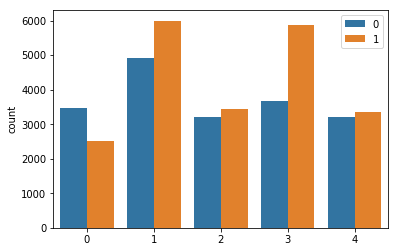

In [365]:
# Plot showing distribution of clusters across dependent variable
df1_Kmeans_rand = KMeans(n_clusters=5,random_state=123).fit(df1_random)
sns.countplot(df1_Kmeans_rand.labels_,hue=shares)

#### EM with reduced dimensions 

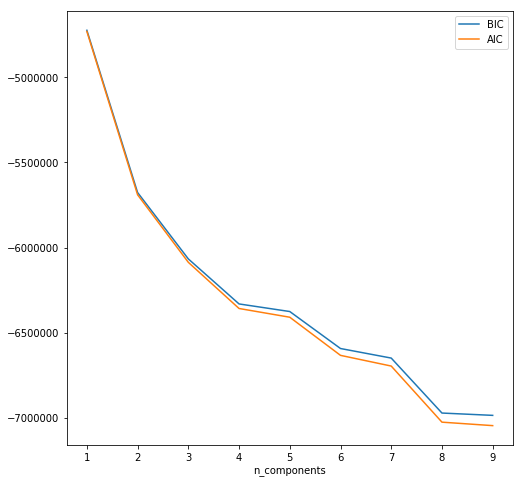

In [215]:
#EM with feature selection
n_components = np.arange(1, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=123).fit(df1_dt)
          for n in n_components]
plt.figure(figsize=(8,8))
plt.plot(n_components, [m.bic(df1_dt) for m in models], label='BIC')
plt.plot(n_components, [m.aic(df1_dt) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

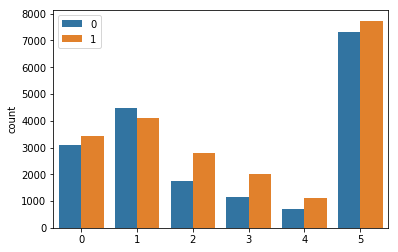

In [366]:
# Plot showing distribution of clusters across dependent variable
df1_EM_dt = GaussianMixture(6, random_state=123).fit(df1_dt)
sns.countplot(df1_EM_dt.predict(df1_dt),hue=shares)

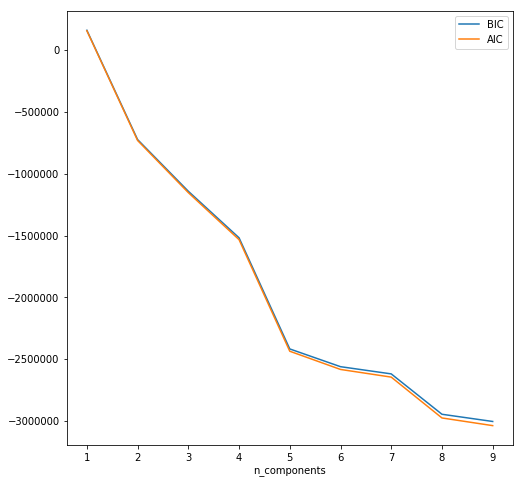

In [112]:
#EM with PCA
n_components = np.arange(1, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=123).fit(df1_PCA)
          for n in n_components]
plt.figure(figsize=(8,8))
plt.plot(n_components, [m.bic(df1_PCA) for m in models], label='BIC')
plt.plot(n_components, [m.aic(df1_PCA) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

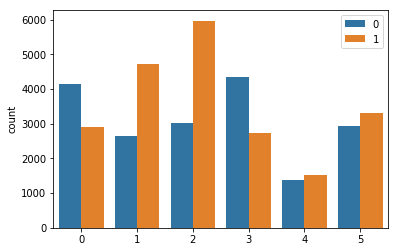

In [367]:
# Plot showing distribution of clusters across dependent variable
df1_EM_pca = GaussianMixture(6, random_state=123).fit(df1_PCA)
sns.countplot(df1_EM_pca.predict(df1_PCA),hue=shares)

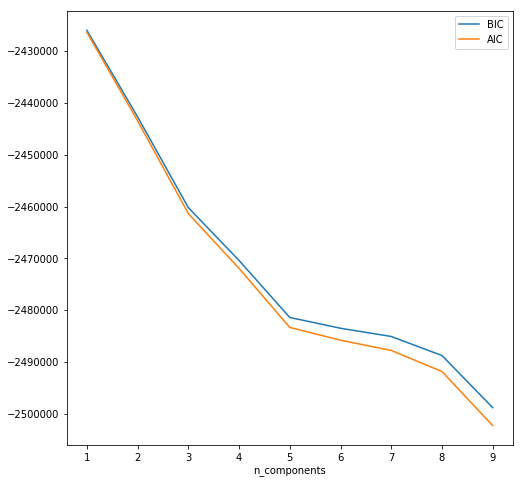

In [113]:
#EM with ICA
n_components = np.arange(1, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=123).fit(df1_ica)
          for n in n_components]
plt.figure(figsize=(8,8))
plt.plot(n_components, [m.bic(df1_ica) for m in models], label='BIC')
plt.plot(n_components, [m.aic(df1_ica) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

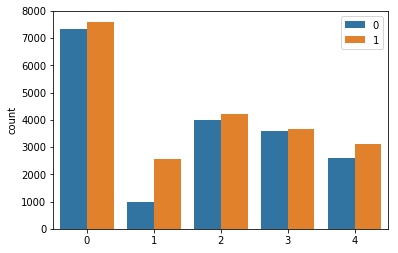

In [369]:
# Plot showing distribution of clusters across dependent variable
df1_EM_ica = GaussianMixture(5, random_state=123).fit(df1_ica)
sns.countplot(df1_EM_ica.predict(df1_ica),hue=shares)

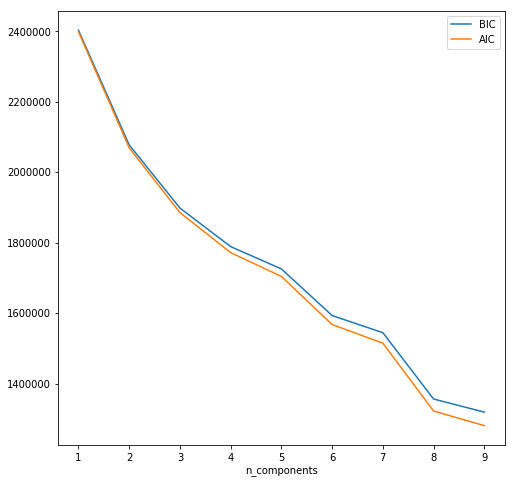

In [114]:
#EM with randomized projections
n_components = np.arange(1, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=123).fit(df1_random)
          for n in n_components]
plt.figure(figsize=(8,8))
plt.plot(n_components, [m.bic(df1_random) for m in models], label='BIC')
plt.plot(n_components, [m.aic(df1_random) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

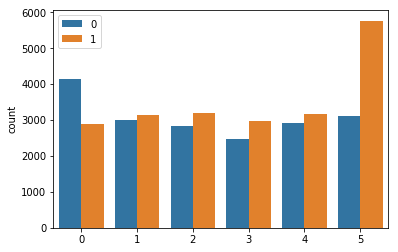

In [370]:
# Plot showing distribution of clusters across dependent variable
df1_EM_rand = GaussianMixture(6, random_state=123).fit(df1_random)
sns.countplot(df1_EM_rand.predict(df1_random),hue=shares)

#### Task 3 findings:
##### K-Means
1. Original K-means resulted in 4 clusters with cluster 4 containing the most number of samples.
2. K-means with tree feature selection resulted in 6 clusters with cluster 6 containing the most number of samples.
3. K-means with PCA resulted in 6 clusters with cluster 3 containing the most number of samples
4. K-means with ICA resulted in 5 clusters with cluster 1 containing the most number of samples
5. K-means with random projections resulted in 6 clusters with cluster 6 containing the most number of samples.
6. The number of clusters produced with various algorithms is 5 or 6 showing consistency in the grouping.
7. Across all algorithms, there are no clusters with very few or very large number of samples, showing tight grouping.
8. The number of samples is different in different clusters across differnt algorithms which is to be expecetd because of varying criterion for clustering for different algorithms.
##### Expectation Maximization:
1. Original EM resulted in 6 clusters with cluster 2 containing the most number of samples.
2. K-means with tree feature selection resulted in 5 clusters with cluster 3 containing the most number of samples.
3. K-means with PCA resulted in 6 clusters with cluster 6 containing the most number of samples
4. K-means with ICA resulted in 5 clusters with cluster 3 containing the most number of samples
5. K-means with random projections resulted in 5 clusters with cluster 3 containing the most number of samples.
6. The number of clusters produced with various algorithms is 5 or 6 showing consistency in the grouping.
7. Across all algorithms, there are no clusters with very few or very large number of samples, showing tight grouping.
8. The number of samples is different in different clusters across differnt algorithms which is to be expecetd because of varying criterion for clustering for different algorithms.

#### Task 4 

40.46778051282058


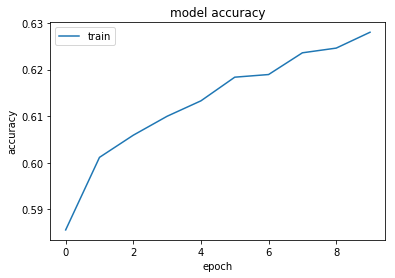

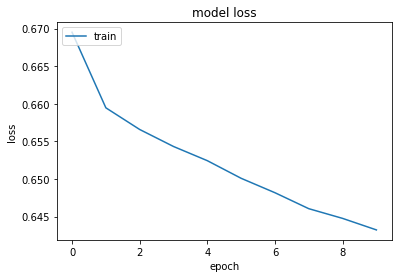

In [357]:
# ANN with feature selection
# Plot showing variation of accuracy and loss with epochs
time_start=time.clock()
model = Sequential()
model.add(Dense(40, input_dim=df1_dt.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(df1_dt, shares, validation_split=0.2, epochs=10, batch_size=32, verbose=0)

time_elapsed = (time.clock() - time_start)
print(time_elapsed)


plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

39.67474338461557


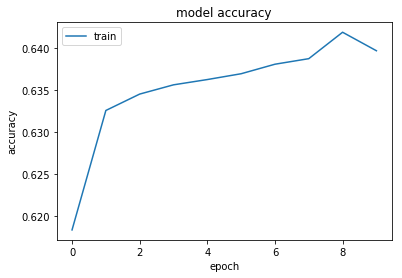

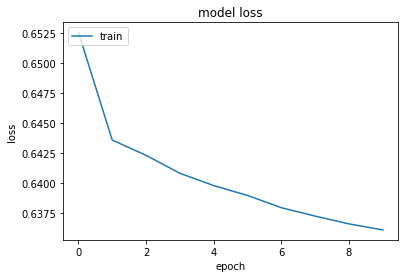

In [358]:
# ANN with PCA
# Plot showing variation of accuracy and loss with epochs
time_start=time.clock()
model = Sequential()
model.add(Dense(40, input_dim=df1_PCA.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(df1_PCA, shares, validation_split=0.2, epochs=10, batch_size=32, verbose=0)

time_elapsed = (time.clock() - time_start)
print(time_elapsed)

plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

44.21683364102569


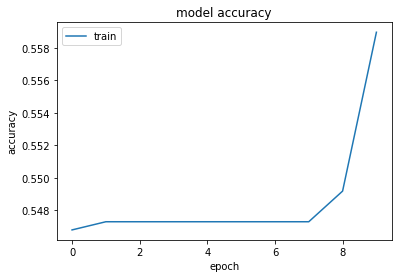

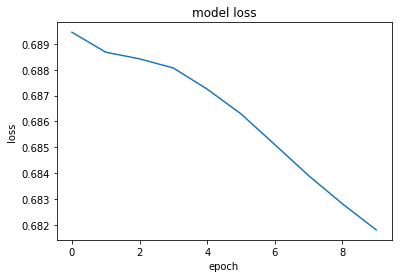

In [359]:
# ANN with ICA
# Plot showing variation of accuracy and loss with epochs
time_start=time.clock()
model = Sequential()
model.add(Dense(40, input_dim=df1_ica.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(df1_ica, shares, validation_split=0.2, epochs=10, batch_size=32, verbose=0)
time_elapsed = (time.clock() - time_start)
print(time_elapsed)

plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

45.81208328205116


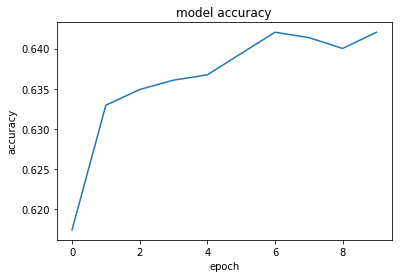

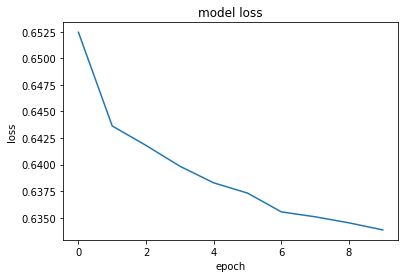

In [360]:
# ANN with randomized projections
# Plot showing variation of accuracy and loss with epochs
time_start=time.clock()
model = Sequential()
model.add(Dense(40, input_dim=df1_random.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(df1_random, shares, validation_split=0.2, epochs=10, batch_size=32, verbose=0)

time_elapsed = (time.clock() - time_start)
print(time_elapsed)

plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()


plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

#### Task4 findings
1. The original artificial neural network from assignment 3 had an acuracy of 0.65 anf computational time of 55.83 secs.
2. ANN with tree feature selection resulted in an accuracy of 0.63 with computational time of 40.46 secs.
3. ANN with PCA resulted in an accuracy of 0.64 with computational time of 39.6 secs.
4. ANN with ICA resulted in an accuracy of 0.56 with computational time of 44 secs.
5. ANN with randomized projections resulted in an accuracy of 0.65 with computational time of 45 secs.
6. Of the different algorithms, surprisingly randomized projections has the best accuracy score and PCA took the least time of 44 secs. The reduction in computational time is expected because of reduction in number of features.


#### Task 5

45.24331241025652


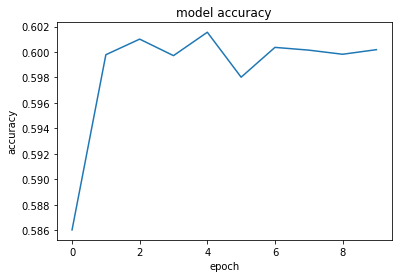

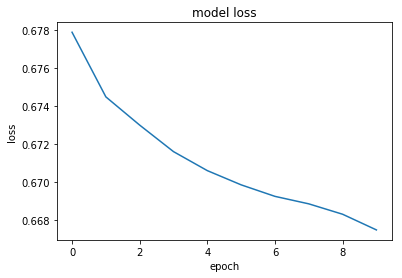

In [361]:
## ANN with clusters from task1 as features
# Plot showing variation of accuracy and loss with epochs
time_start=time.clock()
df1_clust = df1_t[['KMeans_clusters','EM_clusters']]
df1_clust = pd.get_dummies(df1_clust,drop_first=True)
model = Sequential()
model.add(Dense(40, input_dim=df1_clust.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(df1_clust, shares, validation_split=0.3, epochs=10, batch_size=32, verbose=0)
time_elapsed = (time.clock() - time_start)
print(time_elapsed)


plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()


plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

#### Task 5 findings:
1. With the clsuters labels from task1, ANN resulted in an accuracy score of 60% showing that the grouping was consistent
2. The time taken is 45 secs which is less than the 55 secs taken for the origianl features.

#### Dataset 2

In [132]:
data1=pd.read_csv('census.csv')

In [133]:
income_raw = data1['income']
features_raw = data1.drop('income', axis = 1)
#log transforming numerical money features capital-gain and capital-loss. Added 1 as some values are 0.
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data1[skewed].apply(lambda x: np.log(x + 1))
#Scaling of numerical features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data1[numerical])

####  conversion of income to two classes based on whether its greater than 50k.
As variables like work class, education_level, sex etc are categorical, they are converted to dummy variables and one dummy variable is dropped for each original variable to get rid of dummy trap 

In [142]:
features1 = pd.get_dummies(features_raw,drop_first=True)
df2_t = pd.get_dummies(features_raw,drop_first=True)
income = income_raw.apply(lambda x: 1 if x == '>50K' else 0)

#### Task 1

#### K-Means for dataset2

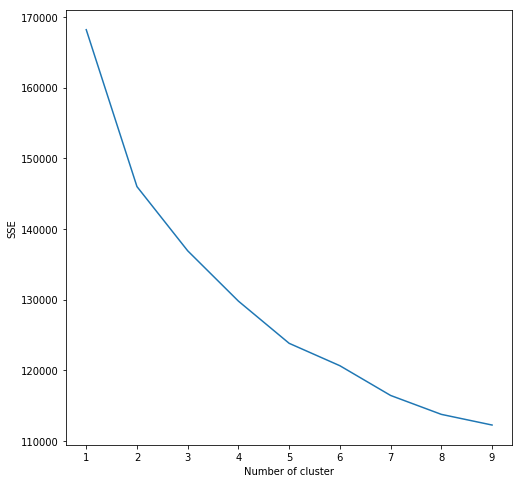

In [144]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k,random_state=123).fit(features1)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(8,8))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

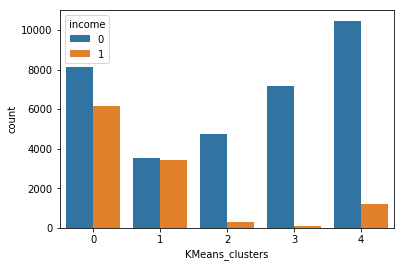

In [283]:
# Plot showing distribution of clusters across dependent variable
df2_Kmeans = KMeans(n_clusters=5,random_state=123).fit(features1)
df2_t['KMeans_clusters'] = df2_Kmeans.labels_
sns.countplot(df2_t['KMeans_clusters'],hue=income)

#### Findings:
1. Using the elbow method, the optimum number of clusters is 5.
2. Cluster 4 has the most number of shares-1 class label
3. Cluster 3 has the least number of shares-0 class label
4. Clusters 3,4 and 5  predominantly represent people with income less than $50,000

#### Expectation Maximization

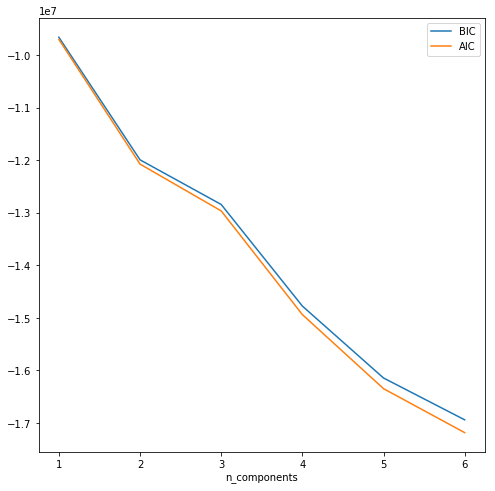

In [296]:
n_components = np.arange(1, 7)
models = [GaussianMixture(n, covariance_type='full', random_state=1).fit(features1)
          for n in n_components]
plt.figure(figsize=(8,8))
plt.plot(n_components, [m.bic(features1) for m in models], label='BIC')
plt.plot(n_components, [m.aic(features1) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

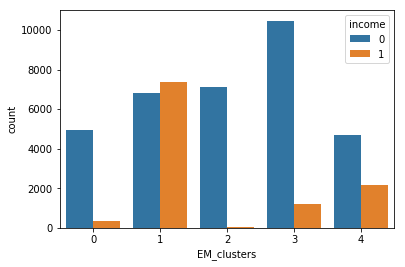

In [297]:
# Plot showing distribution of clusters across dependent variable
df2_EM = GaussianMixture(5, random_state=1).fit(features1)
df2_t['EM_clusters'] = df2_EM.predict(features1)
sns.countplot(df2_t['EM_clusters'],hue=income)

#### Findings
1. Based on elbow method (with both AIC and BIC scores), the optimum number of clusters is 5
2. TClustr 2 has the most number of samples and has almost equal number of class labels(income-0 and 1)
3. Cluster 3 has the most number of samples class labels (shares-0 )
4. Clusters 1,3 and 4  predominantly represent people with income less than $50,000

#### Dimensionality Reduction

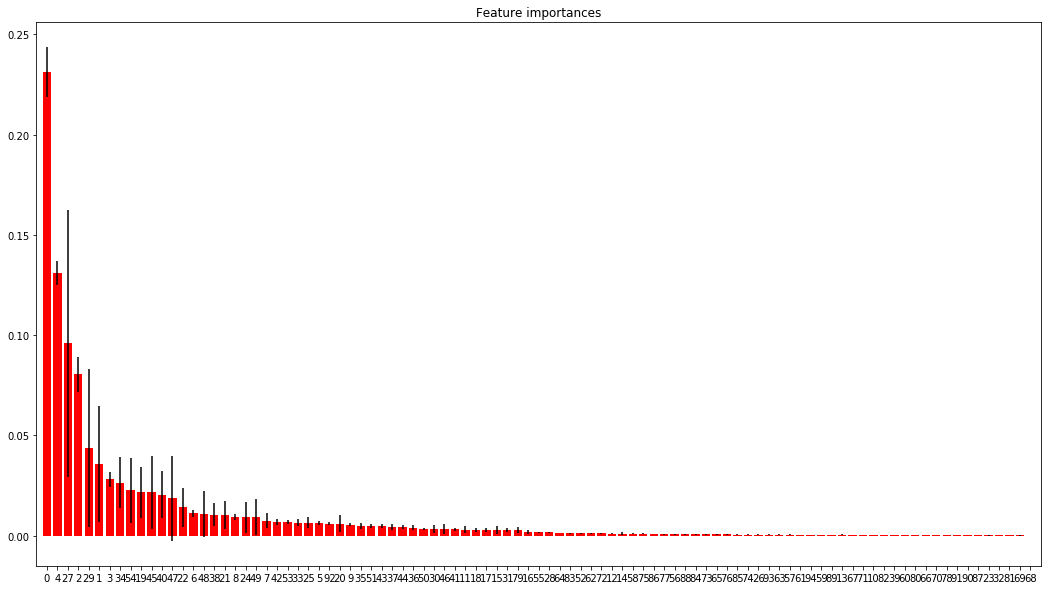

In [289]:
#Graph showing the feature importances of the original features
X=features1
y=income
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=123)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]


# Plot the feature importances of the forest
plt.figure(figsize=(18,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [290]:
# Dimensionality reduction using tree feature selection
model = SelectFromModel(forest, prefit=True)
df2_dt = pd.DataFrame(model.transform(X))

#### PCA for second dataset

In [298]:
pca=PCA(.90).fit(features1)
#pca.explained_variance_ratio_.sum()
pca.n_components_

28

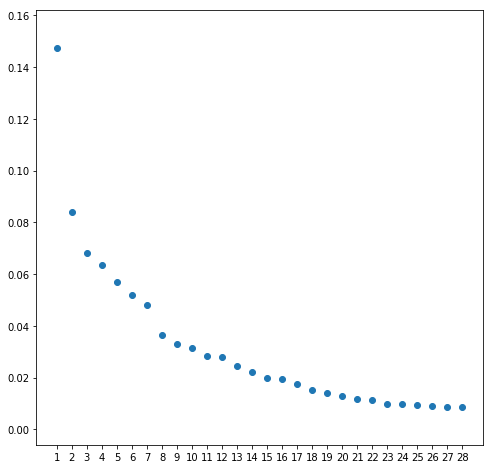

In [303]:
# Plot showing feature variance after PCA
df2_PCA = pd.DataFrame(PCA(n_components=28).fit_transform(features1))
plt.figure(figsize=(8,8))
plt.scatter(list(range(1,29)),pca.explained_variance_ratio_)
plt.xticks(range(1,29))
plt.show()

#### ICA for second dataset

In [304]:
df2_ICA = pd.DataFrame(FastICA().fit_transform(features1))

C:\Users\pvloh\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


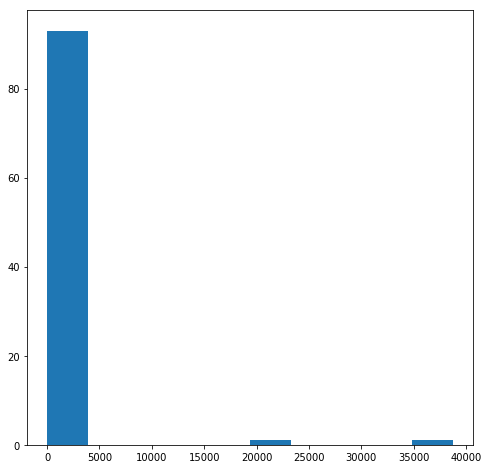

In [331]:
#PLot showing distribution of kurtosis score after ICA
df2_kurtosis = []
for column in df2_ICA:
    df2_kurtosis.append(kurtosis(df2_ICA[column],fisher=True))
plt.figure(figsize=(8,8))
plt.hist(df2_kurtosis)
plt.show()

In [333]:
df2_ica = pd.DataFrame()
for column in df2_ICA:
    if abs(kurtosis(df2_ICA[column],fisher=True)) < 2 :
        df2_ica[column]=df2_ICA[column]

#### RandomProjection for dataset2

In [334]:
df2_random = pd.DataFrame(custom1(features1, 95, 48))

#### Findings for task 2 dataset 2
1. Feature selection(using trees) algorithm chose 16 features as the best features. 
2. The graph for feature selection shows that the highest variance explained by a feature is 0.24. 5 -6 features show the most variance
3. With 90% explained variance, PCA resulted in 28 features.
4. The plot for the PCA shows that the the highest variance explained by a feature is 0.15, which is a has decreased compared to the original variance.
5. Using kurtosis distance as a metric (absolute value greater than 2), ICA resulted in 10 features. 
6. The graph for ICA shows that almost 90% of new features have kurtosis distance in the 0-5000 range with 10 below 2.Absolte value of kurtosis distance was used.
7. Using a ramdom matrix, 48(~half of original number of features) was chosen as the new featues from randomized projections.

#### Task 3:Clustering with dimensionality reduced data

#### K-means with reduced dimensions 

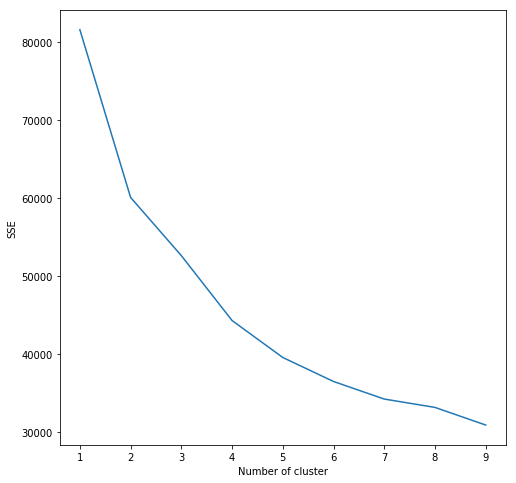

In [338]:
# K-means with feature selection
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k,random_state=100).fit(df2_dt)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(8,8))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

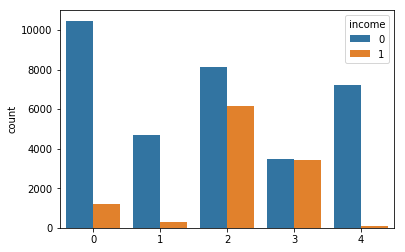

In [385]:
# Plot showing distribution of clusters across dependent variable
df2_Kmeans_dt = KMeans(n_clusters=5,random_state=123).fit(df2_dt)
sns.countplot(df2_Kmeans_dt.labels_,hue=income)

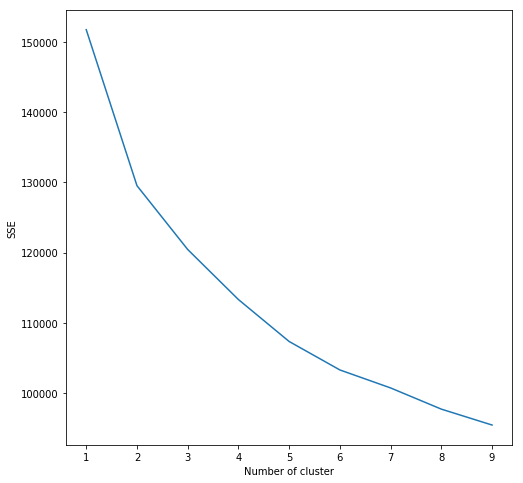

In [168]:
#K-means with PCA
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k,random_state=123).fit(df2_PCA)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(8,8))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

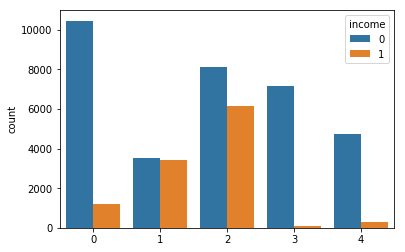

In [384]:
# Plot showing distribution of clusters across dependent variable
df2_Kmeans_pca = KMeans(n_clusters=5,random_state=123).fit(df2_PCA)
sns.countplot(df2_Kmeans_pca.labels_,hue=income)

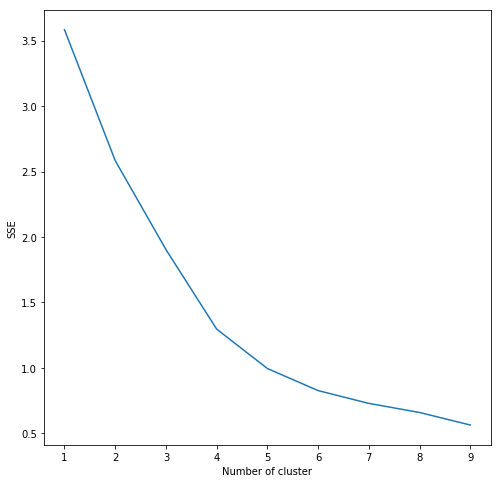

In [169]:
#K-means with ICA
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k,random_state=123).fit(df2_ica)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(8,8))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

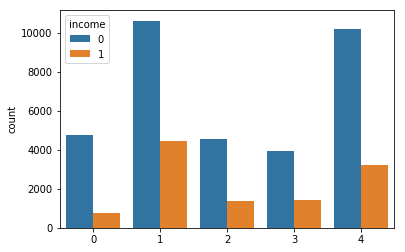

In [381]:
# Plot showing distribution of clusters across dependent variable
df2_Kmeans_ica = KMeans(n_clusters=5,random_state=123).fit(df2_ica)
sns.countplot(df2_Kmeans_ica.labels_,hue=income)

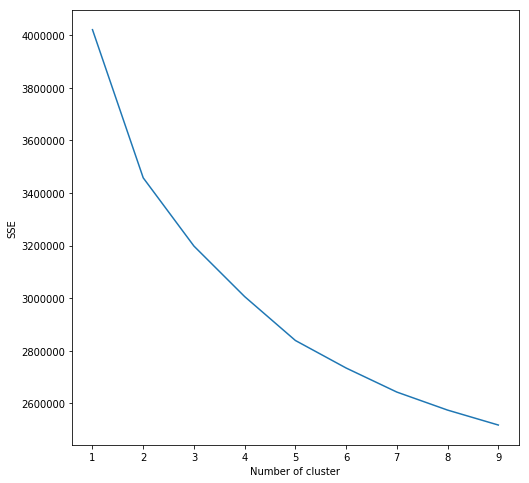

In [339]:
#K-means with randomized projections
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k,random_state=100).fit(df2_random)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure(figsize=(8,8))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

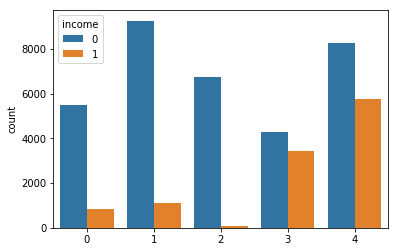

In [380]:
# Plot showing distribution of clusters across dependent variable
df2_Kmeans_rand = KMeans(n_clusters=5,random_state=123).fit(df2_random)
sns.countplot(df2_Kmeans_rand.labels_,hue=income)

#### EM with reduced dimensions 

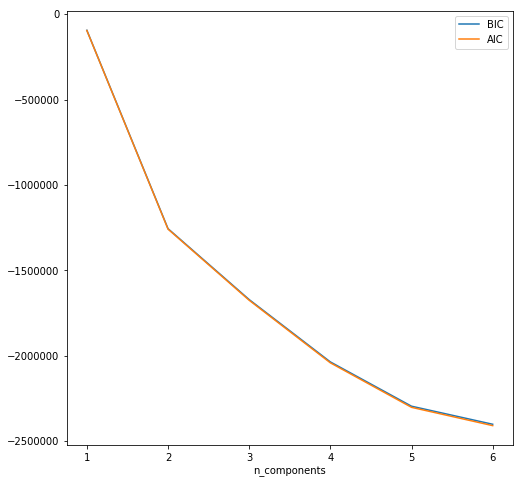

In [345]:
#EM with feature selection
n_components = np.arange(1, 7)
models = [GaussianMixture(n, covariance_type='full', random_state=123).fit(df2_dt)
          for n in n_components]
plt.figure(figsize=(8,8))
plt.plot(n_components, [m.bic(df2_dt) for m in models], label='BIC')
plt.plot(n_components, [m.aic(df2_dt) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

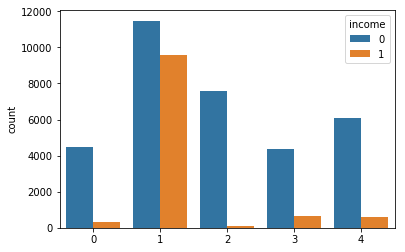

In [378]:
# Plot showing distribution of clusters across dependent variable
df2_EM_dt = GaussianMixture(5,random_state=123).fit(df2_dt)
sns.countplot(df2_EM_dt.predict(df2_dt),hue=income)

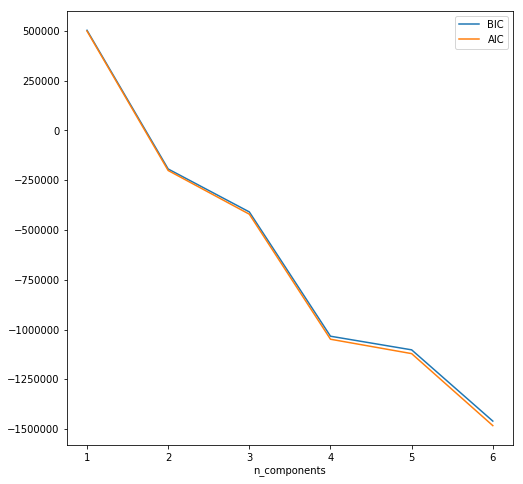

In [349]:
#EM with PCA
n_components = np.arange(1, 7)
models = [GaussianMixture(n, covariance_type='full', random_state=123).fit(df2_PCA)
          for n in n_components]
plt.figure(figsize=(8,8))
plt.plot(n_components, [m.bic(df2_PCA) for m in models], label='BIC')
plt.plot(n_components, [m.aic(df2_PCA) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

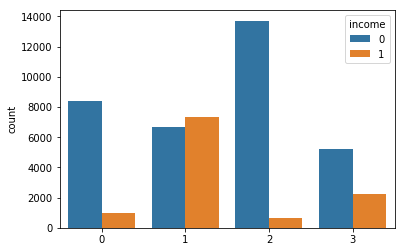

In [375]:
# Plot showing distribution of clusters across dependent variable
df2_EM_pca = GaussianMixture(4, random_state=123).fit(df2_PCA)
sns.countplot(df2_EM_pca.predict(df2_PCA),hue=income)

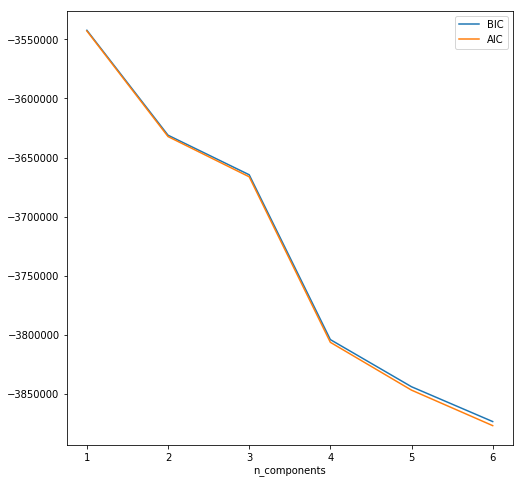

In [346]:
#EM with ICA
n_components = np.arange(1, 7)
models = [GaussianMixture(n, covariance_type='full', random_state=123).fit(df2_ica)
          for n in n_components]
plt.figure(figsize=(8,8))
plt.plot(n_components, [m.bic(df2_ica) for m in models], label='BIC')
plt.plot(n_components, [m.aic(df2_ica) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

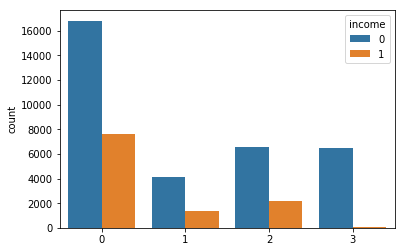

In [373]:
# Plot showing distribution of clusters across dependent variable
df2_EM_ica = GaussianMixture(4, random_state=123).fit(df2_ica)
sns.countplot(df2_EM_ica.predict(df2_ica),hue=income)

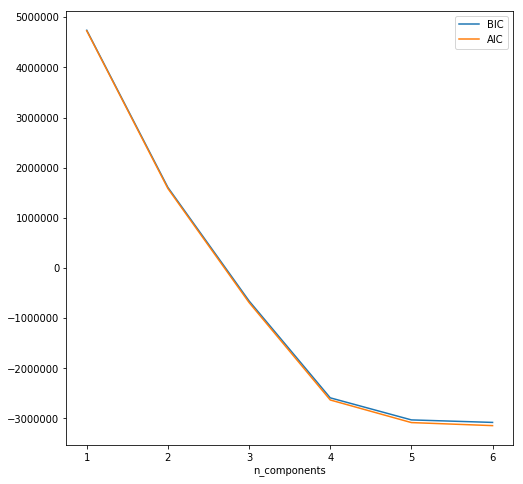

In [347]:
#EM with randomized projections
n_components = np.arange(1, 7)
models = [GaussianMixture(n, covariance_type='full', random_state=123).fit(df2_random)
          for n in n_components]
plt.figure(figsize=(8,8))
plt.plot(n_components, [m.bic(df2_random) for m in models], label='BIC')
plt.plot(n_components, [m.aic(df2_random) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

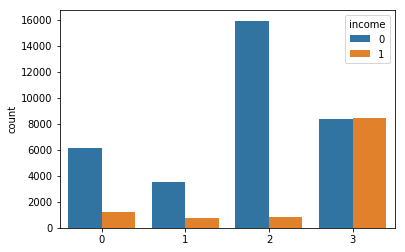

In [372]:
# Plot showing distribution of clusters across dependent variable
df2_EM_rand = GaussianMixture(4, random_state=123).fit(df2_random)
sns.countplot(df2_EM_rand.predict(df2_random),hue=income)

#### Task 3 findings:
##### K-Means
1. Original K-means resulted in 5 clusters with clusters 2,3,4 predominantly represent people with less than 50000 income.
2. K-means with tree feature selection resulted in 5 clusters with clusters 1,2,5 predominantly represent people with less than 50000 income.  
3. K-means with PCA resulted in 5 clusters with clusters 1,4,5 predominantly represent people with less than 50000 income.  
4. K-means with ICA resulted in 5 clusters with clusters 1,5 predominantly represent people with less than 50000 income.  
5. K-means with random projections resulted in 5 clusters with clusters 1,2,3 predominantly represent people with less than 50000 income.  
6. The number of clusters produced with various algorithms is 5  showing consistency in the grouping.
7. Across all algorithms, there are no clusters with very few or very large number of samples, showing tight grouping.
8. The number of samples is different in different clusters across differnt algorithms which is to be expecetd because of varying criterion for clustering for different algorithms.
##### Expectation Maximization:
1. Original EM resulted in 5 clusters with clusters 1,2,3 predominantly represent people with less than 50000 income.  
2. K-means with tree feature selection resulted in 5 clusters with clusters 1,2,3 predominantly represent people with less than 50000 income and cluster 1 representing people with more than 50,000 income.
3. K-means with PCA resulted in 4 clusters with  clusters 1,2 predominantly represent people with less than 50000 income.  
4. K-means with ICA resulted in 4 clusters with cluster 3 predominantly represent people with less than 50000 income.  
5. K-means with random projections resulted in 4 clusters with clusters 1,2,3 predominantly represent people with less than 50000 income and cluster 4 representing people with more than 50,000 income.
6. The number of clusters produced with various algorithms is 5 or 6 showing consistency in the grouping.
7. Across all algorithms, there are no clusters with very few or very large number of samples, showing tight grouping.
8. The number of samples is different in different clusters across differnt algorithms which is to be expecetd because of varying criterion for clustering for different algorithms.

#### Task4: Neural networks with dimensionality reduction

127.12119097435898


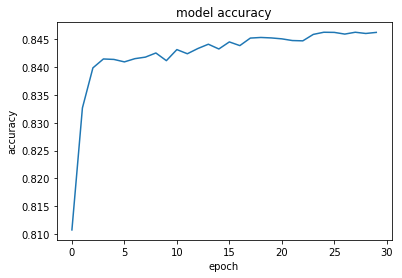

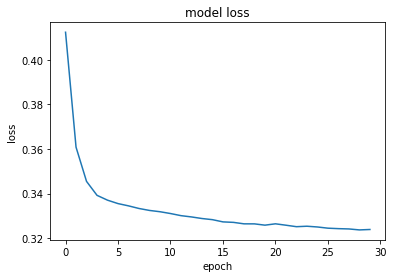

In [351]:
# ANN with feature selection
# Plot showing variation of accuracy and loss with epochs
import time
time_start=time.clock()
model = Sequential()
model.add(Dense(40, input_dim=df2_dt.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(df2_dt, income, validation_split=0.2, epochs=30, batch_size=32, verbose=0)
time_elapsed = (time.clock() - time_start)
print(time_elapsed)

plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()


plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

140.7846916923077


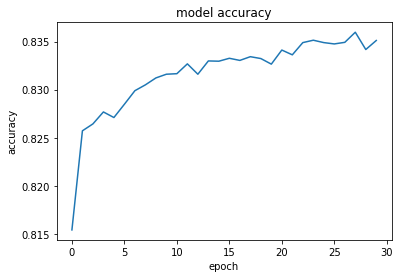

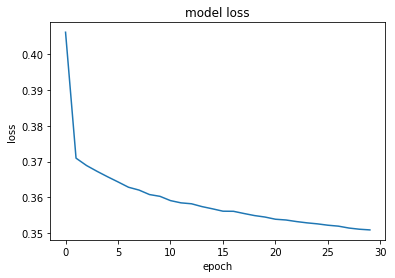

In [352]:
# ANN with PCA
# Plot showing variation of accuracy and loss with epochs
import time
time_start=time.clock()
model = Sequential()
model.add(Dense(40, input_dim=df2_PCA.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(df2_PCA, income, validation_split=0.2, epochs=30, batch_size=32, verbose=0)
time_elapsed = (time.clock() - time_start)
print(time_elapsed)

plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()


plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

140.71217435897438


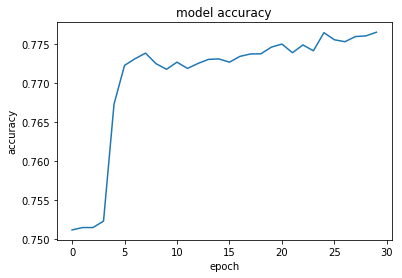

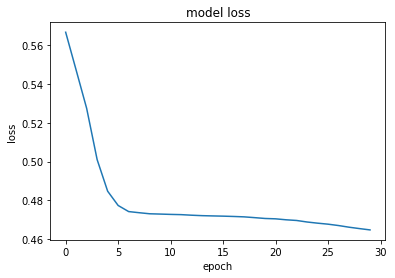

In [354]:
# ANN with ICA
# Plot showing variation of accuracy and loss with epochs
import time
time_start=time.clock()
model = Sequential()
model.add(Dense(40, input_dim=df2_ica.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(df2_ica, income, validation_split=0.2, epochs=30, batch_size=32, verbose=0)
time_elapsed = (time.clock() - time_start)
print(time_elapsed)

plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()


plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

147.93244758974356


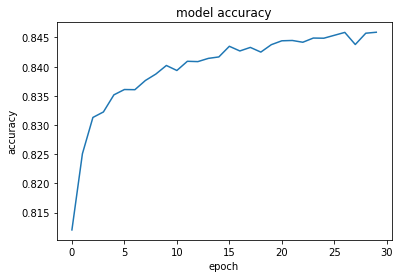

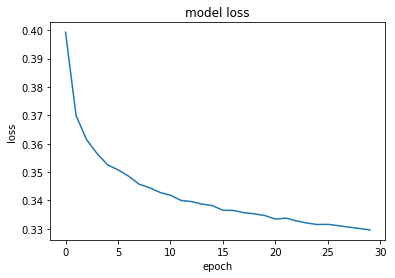

In [355]:
# ANN with randomized projections
# Plot showing variation of accuracy and loss with epochs
import time
time_start=time.clock()
model = Sequential()
model.add(Dense(40, input_dim=df2_random.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(df2_random, income, validation_split=0.2, epochs=30, batch_size=32, verbose=0)
time_elapsed = (time.clock() - time_start)
print(time_elapsed)

plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()


plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

#### Task4 findings
1. The original artificial neural network from assignment 3 had an acuracy of 0.85 anf computational time of 158 secs.
2. ANN with tree feature selection resulted in an accuracy of .845 with computational time of 127 secs.
3. ANN with PCA resulted in an accuracy of 0.835 with computational time of 140 secs.
4. ANN with ICA resulted in an accuracy of 0.775 with computational time of 140 secs.
5. ANN with randomized projections resulted in an accuracy of 0.84.5 with computational time of 147 secs.
6. Of the different algorithms, feature has the best accuracy score and took the least amount of time. This is to be expected as there a large number of dummy variables in the original feature set. The reduction in computational time is expected because of reduction in number of features.

#### Task 5

141.681696


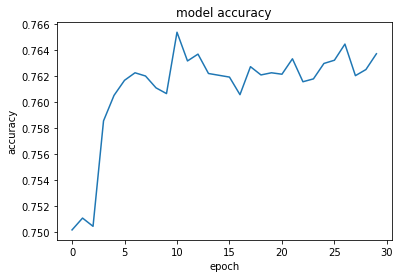

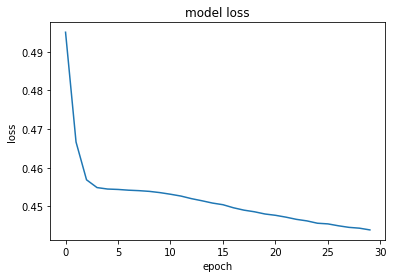

In [356]:
## ANN with clusters from task1 as features
# Plot showing variation of accuracy and loss with epochs
df2_clust = df2_t[['KMeans_clusters','EM_clusters']]
df2_clust = pd.get_dummies(df2_clust,drop_first=True)
import time
time_start=time.clock()
model = Sequential()
model.add(Dense(40, input_dim=df2_clust.shape[1], kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(df2_clust, income, validation_split=0.2, epochs=30, batch_size=32, verbose=0)
time_elapsed = (time.clock() - time_start)
print(time_elapsed)

plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()


plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

#### Task 5 findings:
1. With the clsuters labels from task1, ANN resulted in an accuracy score of 76% showing that the grouping was consistent
2. The time taken is 141 secs which is less than the 158 secs taken for the original features.

#### Conclusion:
1. The various dimensionality reductions algorithms didnot result in improvement of accuracy score suggesting that there is no curse of dimensionality problem in both the datasets.
2. Though there was no improvement in accuracy score, computational time reduced in with the use of all dimensionality reduction techniques suggesting its use case.
3. In both datasets ICA performed poorly, this is expected as the data is not from indepdent sources.
##### Refrences:
1. http://blog.yhat.com/posts/sparse-random-projections.html
2. https://docs.python.org/3
3. http://scikit-learn.org/stable/index.html
4. https://keras.io/
